# Solving Boundary Value Problems

In addition to finding solutions for an initial value problem (IVP) and estimating the unknown
parameters, this package also allows you to solve boundary value problems (BVP) with a little bit
of imagination. Here, we are going to show how a BVP can be solved by
treating it as a parameter estimation problem. Essentially, a shooting
method where the first boundary condition defines the initial condition
of an IVP and the second boundary condition is an observation. Two
examples, both from the [bvp4c implementation in MATLAB](https://uk.mathworks.com/help/matlab/ref/bvp4c.html), are demonstrated here.


```{note}
These examples are general and not specific to disease scenarios.
```

## Simple model 1

We are trying to find the solution to the second order differential
equation

$$\begin{aligned}
\frac{\mathrm{d}^2 y}{\mathrm{d} t^2} + |y| = 0
\end{aligned}$$

subject to the boundary conditions $y(0) = 0$ and $y(4) = -2$.
Convert this into a set of first order ODEs

$$\begin{aligned}
\frac{\mathrm{d} y}{\mathrm{d} t} &= z \\
\frac{\mathrm{d} z}{\mathrm{d} t} &= -|y|
\end{aligned}$$

Here we set up the system.

In [14]:
from pygom import Transition, TransitionType, SimulateOde, SquareLoss

import matplotlib.pyplot as plt

stateList = ['y', 'z']
paramList = []

ode1 = Transition(origin='y', equation='z', transition_type=TransitionType.ODE)
ode2 = Transition(origin='z', equation='-abs(y)', transition_type=TransitionType.ODE)

model = SimulateOde(stateList, paramList, ode=[ode1, ode2])

model.get_ode_eqn()

Matrix([
[      z],
[-Abs(y)]])

We check that the equations are correct before proceeding to set up our
loss function. The loss function enables us to optimize the parameter choice.

#TODO add some ref/notes for loss functions

In [15]:
import numpy

initialState = [0.0, 1.0]
t = numpy.linspace(0, 4, 100)
model.initial_values = (initialState, t[0])

solution = model.integrate(t[1::])

<Figure size 640x480 with 0 Axes>

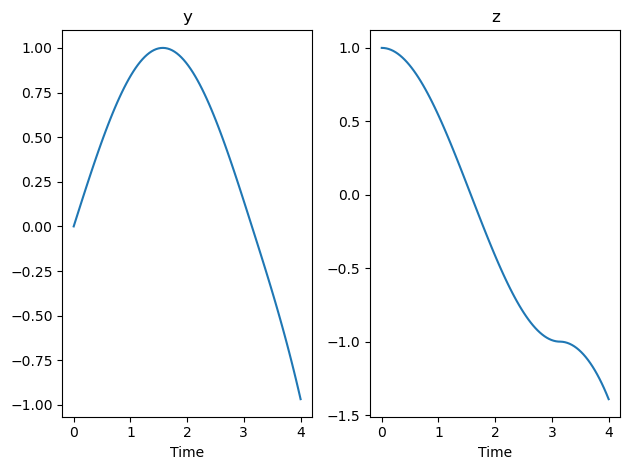

In [16]:
f = plt.figure()
model.plot()


Setting up the second boundary condition $y(4) = -2$ is easy, because
that is only a single observation attached to the state $y_{1}$.
Enforcing the first boundary condition requires us to set it as the
initial condition. Because the condition only states that $y(0) = 0$,
the starting value of the other state $y_1$ is free. We let our loss
object know that it is free through the `targetState` input argument.

#TODO unsure what this means

In [17]:
from scipy.optimize import minimize

theta = [0.0]

obj = SquareLoss(theta=theta,
                 ode=model,
                 t0=t[0], x0=initialState,
                 t=t[-1], y=[-2],
                 state_name=['y'], target_state=['z'])

thetaHat = minimize(fun=obj.costIV, x0=[0.0])
#print(thetaHat)
model.initial_values = ([0.0] + thetaHat['x'].tolist(), t[0])

solution = model.integrate(t[1::])

<Figure size 640x480 with 0 Axes>

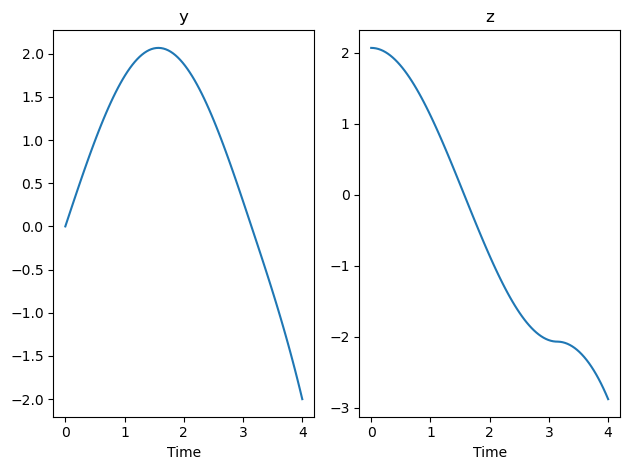

In [18]:
f = plt.figure()
model.plot()
plt.close()


We are going to visualize the solution, and also check the boundary
condition. The first became our initial condition, so it is always
satisfied and only the latter is of concern, which is zero (subject to
numerical error) from thetahat.

#TODO what is thetahat?


## Simple model 2

Our second example is different as it involves an actual parameter and
also time. We have the Mathieu's Equation

#TODO add ref

$$\begin{aligned}
\frac{\mathrm{d}^2 y}{\mathrm{d} t^2} + \left(p - 2q \cos(2t)\right) y = 0
\end{aligned}$$

and the aim is to compute the fourth eigenvalue $q=5$. There are three
boundary conditions

$$\begin{aligned}
\dot{y}(0)=0, \quad \dot{y}(\pi)=0, \quad y(0) = 1
\end{aligned}$$

and we aim to solve it by converting it to a first order ODE and tackle
it as an IVP. As our model object does not allow the use of the time
component in the equations, we introduce a anxiliary state $\tau$ that
replaces time $t$. Rewrite the equations using
$z=\dot{y}(t)$ and define our model as

In [9]:
stateList = ['y', 'z', 'tau']

paramList = ['p']

ode1 = Transition(transition_type=TransitionType.ODE, origin='y', equation='z')
ode2 = Transition(transition_type=TransitionType.ODE, origin='z', equation='-(p - 2*5*cos(2*tau))*y', )
ode3 = Transition(transition_type=TransitionType.ODE, origin='tau', equation='1')

model = SimulateOde(stateList, paramList, ode=[ode1, ode2, ode3])

model.parameters = [('p', 15.0)]

theta = [1.0, 1.0, 0.0]
model.initial_values = (theta, t[0])

t = numpy.linspace(0, numpy.pi)
solution = model.integrate(t[1::])

<Figure size 640x480 with 0 Axes>

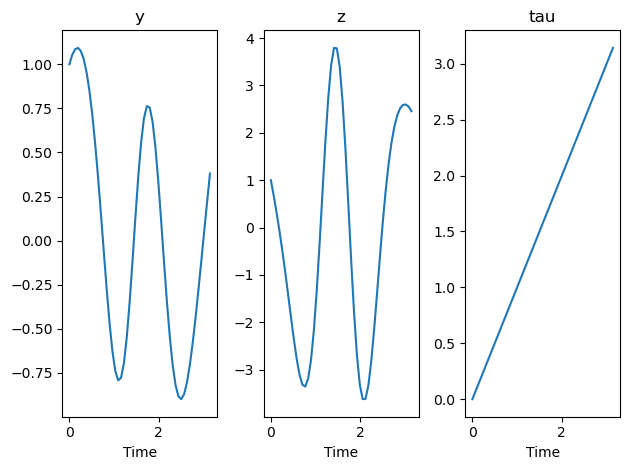

In [10]:
f = plt.figure()
model.plot()
plt.close()


Now we are ready to setup the estimation. Like before, we set up the
second boundary condition by pretending that it is an observation. We
have all the initial conditions defined by the first boundary condition.

In [11]:
obj = SquareLoss(15.0,
                 ode=model,
                 t0=t[0], x0=[1.0, 0.0, 0.0], 
                 t=t[-1], y=0.0,
                 state_name='y')

obj = SquareLoss(theta=theta,
                 ode=model,
                 t0=t[0], x0=initialState,
                 t=t[-1], y=[-2],
                 state_name=['y'], target_state=['z'])

xhatObj = minimize(obj.cost,[15])

print(xhatObj)

model.parameters = [('p', xhatObj['x'][0])]

model.initial_values = ([1.0, 0.0, 0.0], t[0])

solution = model.integrate(t[1::])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.6125586631762084e-15
        x: [ 1.349e+01]
      nit: 5
      jac: [ 7.657e-08]
 hess_inv: [[ 1.759e+00]]
     nfev: 12
     njev: 6


<Figure size 640x480 with 0 Axes>

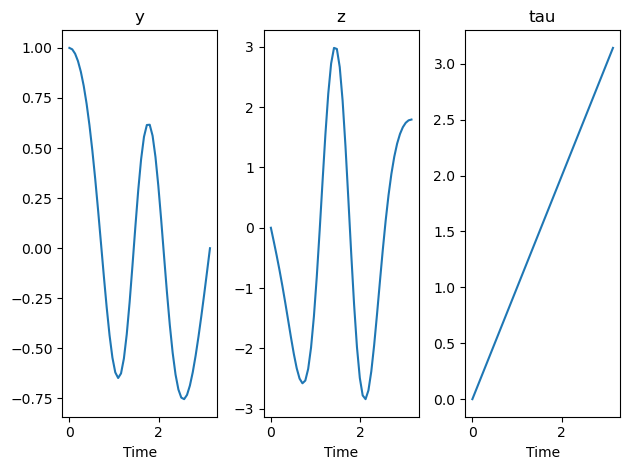

In [12]:
f = plt.figure()

model.plot()

plt.close()


The plot of the solution shows the path that satisfies all boundary
condition. The last subplot is time, which is redundant here but
the `DeterministicOde.plot` method is not yet able to recognize the time
component. Possible speed up can be achieved through the use of
derivative information or via the root finding method that tackles the
gradient directly, instead of the cost function.

#TODO add meth/fun/class refs for root finding method, derivative


**Reference**

[1] <http://uk.mathworks.com/help/matlab/ref/bvp4c.html>